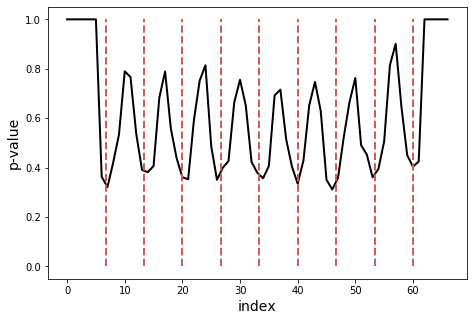

In [92]:
import pandas as pd
import numpy as np
import math
from scipy import stats
import matplotlib.pyplot as plt

def upload_log(path):
    log = pd.read_csv(path)
    log = log.query('type == "assign"')\
    [['id','activity_name']]
    return log

def rename_activities(log):
    alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 
                'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 
                'u', 'v', 'w', 'x', 'y', 'z']
    activities = list(log.activity_name.unique())
    activity_dict = dict([])
    for i in range(len(activities)):
        activity_dict[activities[i]] = alphabet[i]
    for i in range(len(log1)):
        log.iloc[i].activity_name = activity_dict[log.iloc[i].activity_name]
    return log, log.activity_name.unique()

def compact_form(log):
    new_log = []
    for i in range(len(log)):
        if not i:
            trace_id = log.iloc[i].id
            trace = ''
        if log.iloc[i].id == trace_id:
            trace += log.iloc[i].activity_name
        else:
            new_log += [trace]
            trace = log.iloc[i].activity_name
            trace_id = log.iloc[i].id
        if i == len(log) - 1:
            new_log += [trace]
    return new_log

def D(log, activities, n, l):
    sublogs = []
    for i in range(0, len(log), n):
        sublogs += [''.join(log[i:i + n])]
    D = []
    for sublog in sublogs:
        Jm_values = []
        for i in range(len(activities)):
            for j in range(len(activities)):
                Jm_values += [Jmeasure(sublog, l, activities[i], 
                                       activities[j])]
        D += [Jm_values]
    return np.array(D)

def FS_cardinalities(sublog, l, activity1, activity2):
    S = []
    count = 0
    for i in range(len(sublog)):
        if sublog[i] == activity1:
            try:
                S += [sublog[i : i + l]]
            except IndexError:
                S += [sublog[i :]]
    for i in S:
        if activity2 in i:
            count += 1
    return count, len(S)

def probability(sublog, *args):
    if len(args) == 1:
        return sublog.count(args[0]) / len(sublog)
    else:
        F, S = FS_cardinalities(sublog, l, args[0], args[1])
        if not S:
            return 0
        else:
            return F / S

def Jmeasure_logarithm(numerator, denominator):
    if not numerator * denominator:
        return 0
    return math.log(numerator / denominator, 2)

def Jmeasure(sublog, l, activity1, activity2):
    p_1 = probability(sublog, activity1)
    p_2 = probability(sublog, activity2)
    p_12 = probability(sublog, l, activity1, activity2) 
    return p_1 * (p_12 * Jmeasure_logarithm(p_12,
                                            p_2)\ 
                  + (1 - p_12) *\
                  Jmeasure_logarithm(1 - p_12, 1 - p_2))

def WC(sublog, l, activity1, activity2):
    return FS_cardinalities(sublog, l, activity1, activity2)[0]

def hypothesis_test(D, w):
    total_p_values = []
    for i in range(len(D) - 2 * w + 1):
        P_1 = D[i : w + i]
        P_2 = D[i + w : i + 2 * w]
        p_values = []
        for j in range(np.shape(D)[1]):
            try:
                p_values += [stats.ks_2samp([P_1[k][j] for k in range(w)],
                                            [P_2[k][j] for k in range(w)])[1]]
            except ValueError:
                p_values += [1]
        total_p_values += [np.mean(p_values)]
    return [1] * w + total_p_values + [1] * (w - 1)

def visualization(p_values, n):
    fig = plt.figure(1, figsize=(7.5, 5))
    plt.plot(p_values, color = 'k', lw = 2)
    for i in range(1,10):
        plt.plot([5000 / 10 / n * i] * 2, [0, 1], '--', lw = 2, color = 'indianred')
    plt.xlabel('index', fontsize = 14)
    plt.ylabel('p-value', fontsize = 14)
    plt.show()

def main():
    log = upload_log('DATA/logs/csv/IRO5k.csv')
    log, activities = rename_activities(log)
    log = compact_form(log)
    n, l, w = 75, 5, 6
    p_values = hypothesis_test(D(log, activities, n, l), w)
    visualization(p_values, n)

if __name__ == '__main__':
    main()